In [471]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

np.set_printoptions(linewidth=150)
pd.set_option('display.max_columns', 500)

# Parse Helpers

In [472]:
log1 = open("model_testbed.log","r").read()
log2 = open("logs/model_testbed.log","r").read()
log = log1+log2
outs = log.split("NEW MODEL ")[1:]


def line_format(line,add_quotes=True):
    if ("INFO" not in line or 'cell:' in line) and "[" in line and "]" in line:
        if "," not in line:
            if "." in line:
                line = re.sub('(?<=\d)\.+',",",line)
            else:
                line = re.sub('(?<=\d)\s+',",",line)
    if "torch.utils.data" in line:
        line = line.replace("<","'").replace(">","'")
            
            
    line = line.replace("\n","").replace(" ","").replace("array","np.array").replace("\e[1m","").replace("\e[21mN","")
    if add_quotes:
        if ":" in line:
            name,val = line.split(":",1)
            if name=='prefix':
                return '"{}":"{}"'.format(name.strip(),val)
            else:
                return '"{}":{}'.format(name.strip(),val)
    return line


def general_stats(line,current,start_cond,end_cond,stats_str):
    if start_cond in line:
        current = start_cond
        stats_str = line_format(line.split("stats:")[-1],False)
    elif current == start_cond:
        if end_cond in line:
            current = ''
            return True,"{}".format(stats_str),current

        else:
            stats_str += '{}'.format(line_format(line,False))
    return False,stats_str,current
            
def specific_stats(line,current,start_cond,end_cond,stats_str=""):
    #print(current,[(x,line,x in line) for x in end_cond])
    if start_cond in line:
        current = start_cond
        stats_str = ""
    
    elif current == start_cond:
        if any([x in line for x in end_cond]):
            current = ''
            return True,"{{{}}}".format(stats_str.rsplit(",",1)[0]),current
        elif line[-1]==",":
            #print("pre add ",stats_str)
            stats_str += '{}'.format(line_format(line.split("run:")[-1]))
            #print("post add",stats_str)
        else:
            #print("pre add ",stats_str)
            stats_str += '{}, '.format(line_format(line.split("run:")[-1]))
            #print("post add",stats_str)
    return False,stats_str,current

# Parser

In [500]:
runs = []
for i,out in enumerate(outs):
    print(i,end="\r")
    curve = []
    predictions = []
    current = None
    time_taken = None
    max_val = None
    early_terminate=False
    stats_str = ""
    epoch_time = None
    run_date = None
    
    general_model_stats,general_run_stats,specific_model_stats,specific_run_stats = {},{},{},{}
    #print("--LOOP ENTER--")
    for line in out.split('\n'):
        #print(line)
        if line=="" or ('Loss' in line and 'Corrects' not in line and 'Epoch: 0' not in line):
            pass
        else:
            
            finished,stats_str,current = general_stats(line,current,'Model stats:','Run stats:',stats_str)
            if finished:
                exec("general_model_stats={}".format(stats_str))
                stats_str = ""
                finished = False
                
            finished,stats_str,current = general_stats(line,current,'Run stats:','=====',stats_str)
            if finished:
                exec("general_run_stats={}".format(stats_str))
                stats_str = ""
                finished = False
            
            finished,stats_str,current = specific_stats(line,current,'-- Model stats',[' Run stats '],stats_str)
            if finished:
                exec("specific_model_stats={}".format(stats_str))
                stats_str = ""
                finished = False
            
            if not specific_run_stats:
                finished,stats_str,current = specific_stats(line,current,' Run stats ',['====',"Per epoch","Run finished","Train Epoch: 0"],stats_str)
                if finished:
                    #print("RUN FINISHED")
                    exec("specific_run_stats={}".format(stats_str))
                    stats_str = ""
                    finished = False
            
            if "Corrects" in line:
                curve.append(int(line.split(":")[-1].split("/")[0]))
            if "Prediction" in line:
                if "[[" in line:
                    predictions.append(float(line.split("[[")[-1].split("]]")[0]))
                elif "," in line:
                    predictions.append(float(line.split(":")[-1].split(",")[0]))
                else:
                    predictions.append(float(line.split(":")[-1]))
            if "Time taken" in line:
                time_taken = line.split(":")[-1]
            if "terminated" in line.lower():
                early_terminate=True
            if 'Run started' in line:
                run_date = line.split("at ")[-1]
            if 'Max corrects' in line:
                max_val = int(line.split(":")[-1].split("/")[0])
            if 'Per epoch time' in line:
                epoch_time = line.split(":")[-1].strip()
    #print("--LOOP EXIT--")
    
    stats = {}
    if general_run_stats:
        stats.update(general_run_stats)
    if general_model_stats:
        stats.update(general_model_stats)
    if specific_run_stats:
        stats.update(specific_run_stats)
    if specific_model_stats:
        stats.update(specific_model_stats)
    
    for key in stats.keys():
        new_key = key.strip().replace('matrix','matrices')
        #print(key)
        if key=='cell':
            new_key='cell_matrices'
        if key=='momemtum':
            new_key = 'momentum'
        if new_key!=key:
            stats[new_key] = stats.pop(key)
        
    stats['curve']=curve
    stats['predictions']=predictions
    stats['epoch']=len(curve)
    stats['time_taken']=time_taken
    stats['early_terminate']=early_terminate
    stats['per_epoch_time']=epoch_time
    if not max_val:
        stats['max']=max(curve) if len(curve)>0 else None
    else:
        stats['max']=max_val
    stats['run_date']=run_date
    runs.append(stats)
    
run_stats = pd.DataFrame(runs)
run_stats.to_pickle('run_stats.pkl')
run_stats

,cell_matrices,cell_types,curve,data,drop_path,early_terminate,epoch,epochs,log,lr,lr_schedule,max,momentum,params,per_epoch_time,predictions,prefix,residual_cells,run_date,scale,scales,time_taken,track_progess,track_progress,verbose,weight_decay
0,"[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [0...","[1, 0]","[2512, 4414, 4551, 5161, 5186, 5298, 5543, 581...",(torch.utils.data.dataloader.DataLoaderobjecta...,NaN,False,10,10.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",5813.0,0.9,9490918.0,None,[],NaN,NaN,None,2.0,"(1.0, 1.0)","3 min, 15 s",NaN,NaN,True,0.0001
1,"[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [0...","[1, 0]","[3840, 3939, 4431]",(torch.utils.data.dataloader.DataLoaderobjecta...,NaN,False,3,3.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",4431.0,0.9,9490918.0,None,[],NaN,NaN,None,2.0,"(1.0, 1.0)","1 min, 0 s",NaN,NaN,True,0.0001
2,"[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [0...","[1, 0]","[2376, 3827, 4112]",(torch.utils.data.dataloader.DataLoaderobjecta...,NaN,False,3,3.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",4112.0,0.9,9490918.0,None,[],NaN,NaN,None,2.0,"(1.0, 1.0)","1 min, 1 s",NaN,NaN,True,0.0001
3,"[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [0...","[1, 0]","[4113, 4653]",(torch.utils.data.dataloader.DataLoaderobjecta...,NaN,False,2,3.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",4653.0,0.9,9490918.0,None,[],NaN,NaN,None,2.0,"(1.0, 1.0)",None,NaN,NaN,True,0.0001
4,"[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [0...","[1, 0]",[],(torch.utils.data.dataloader.DataLoaderobjecta...,NaN,False,0,3.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",NaN,0.9,9490918.0,None,[],NaN,NaN,None,2.0,"(1.0, 1.0)",None,NaN,NaN,True,0.0001
5,"[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [0...","[1, 0]",[],(torch.utils.data.dataloader.DataLoaderobjecta...,NaN,False,0,3.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",NaN,0.9,9490918.0,None,[],NaN,NaN,None,2.0,"(1.0, 1.0)",None,NaN,NaN,True,0.0001
6,"[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [0...","[1, 0]",[],(torch.utils.data.dataloader.DataLoaderobjecta...,NaN,False,0,3.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",NaN,0.9,9490918.0,None,[],NaN,NaN,None,2.0,"(1.0, 1.0)",None,NaN,NaN,True,0.0001
7,"[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [0...","[1, 0]",[],(torch.utils.data.dataloader.DataLoaderobjecta...,NaN,False,0,3.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",NaN,0.9,9490918.0,None,[],NaN,NaN,None,2.0,"(1.0, 1.0)",None,NaN,NaN,True,0.0001
8,"[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [0...","[1, 0]","[3849, 4024, 4326]",NaN,NaN,False,3,3.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",4326.0,0.9,9490918.0,None,[],NaN,NaN,2018-10-29 13:38:42,2.0,"(1.0, 1.0)","1 min, 1 s",NaN,NaN,True,0.0001
9,"[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [0...","[1, 0]","[3723, 4252]",NaN,NaN,False,2,3.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",4252.0,0.9,9490918.0,None,[],NaN,NaN,2018-10-29 13:39:58,2.0,"(1.0, 1.0)",None,NaN,NaN,True,0.0001


# Check Predictions

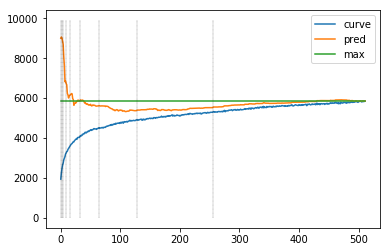

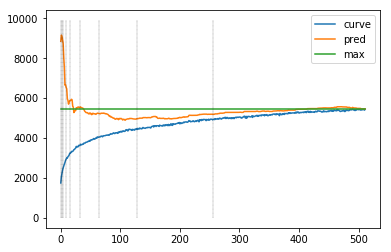

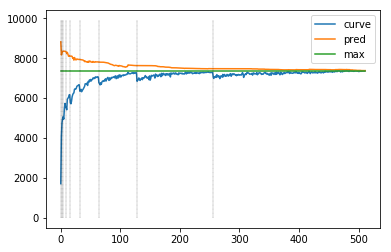

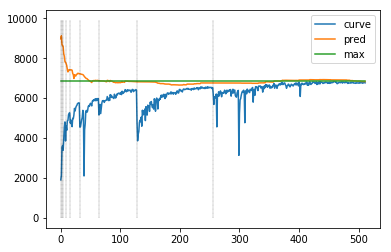

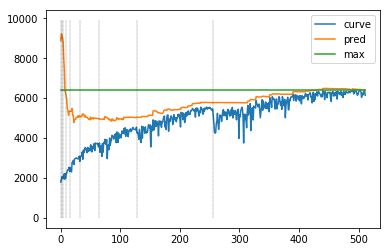

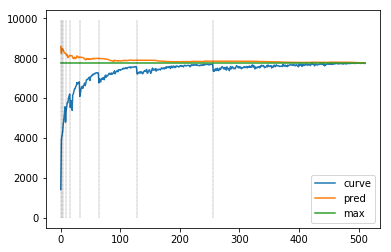

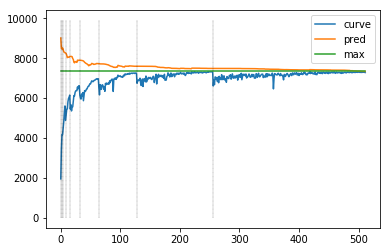

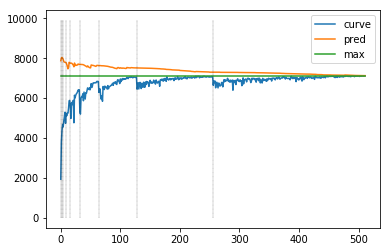

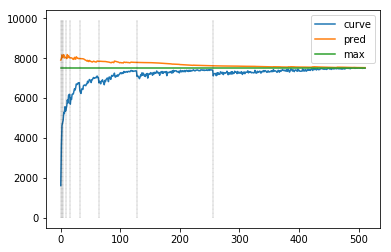

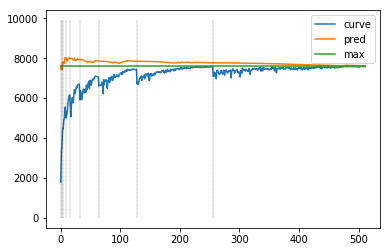

In [474]:
val_preds = run_stats[[len(x)>8 for x in run_stats['predictions']]]
for idx,pred in val_preds.iterrows():
    if len(pred['curve'])>500:
        plt.plot(pred['curve'],label='curve')
        plt.plot(pred['predictions'],label='pred')
        plt.plot([pred['max']]*len(pred['curve']),label='max')
        for i in range(10):
            if 2**i<len(pred['curve']):
                plt.plot([2**i]*100,
                         np.arange(0,10000,100),
                         c='k',
                         linewidth=.25,
                         linestyle="--")
        plt.legend()
        plt.show()

# See all 512 Epoch Runs

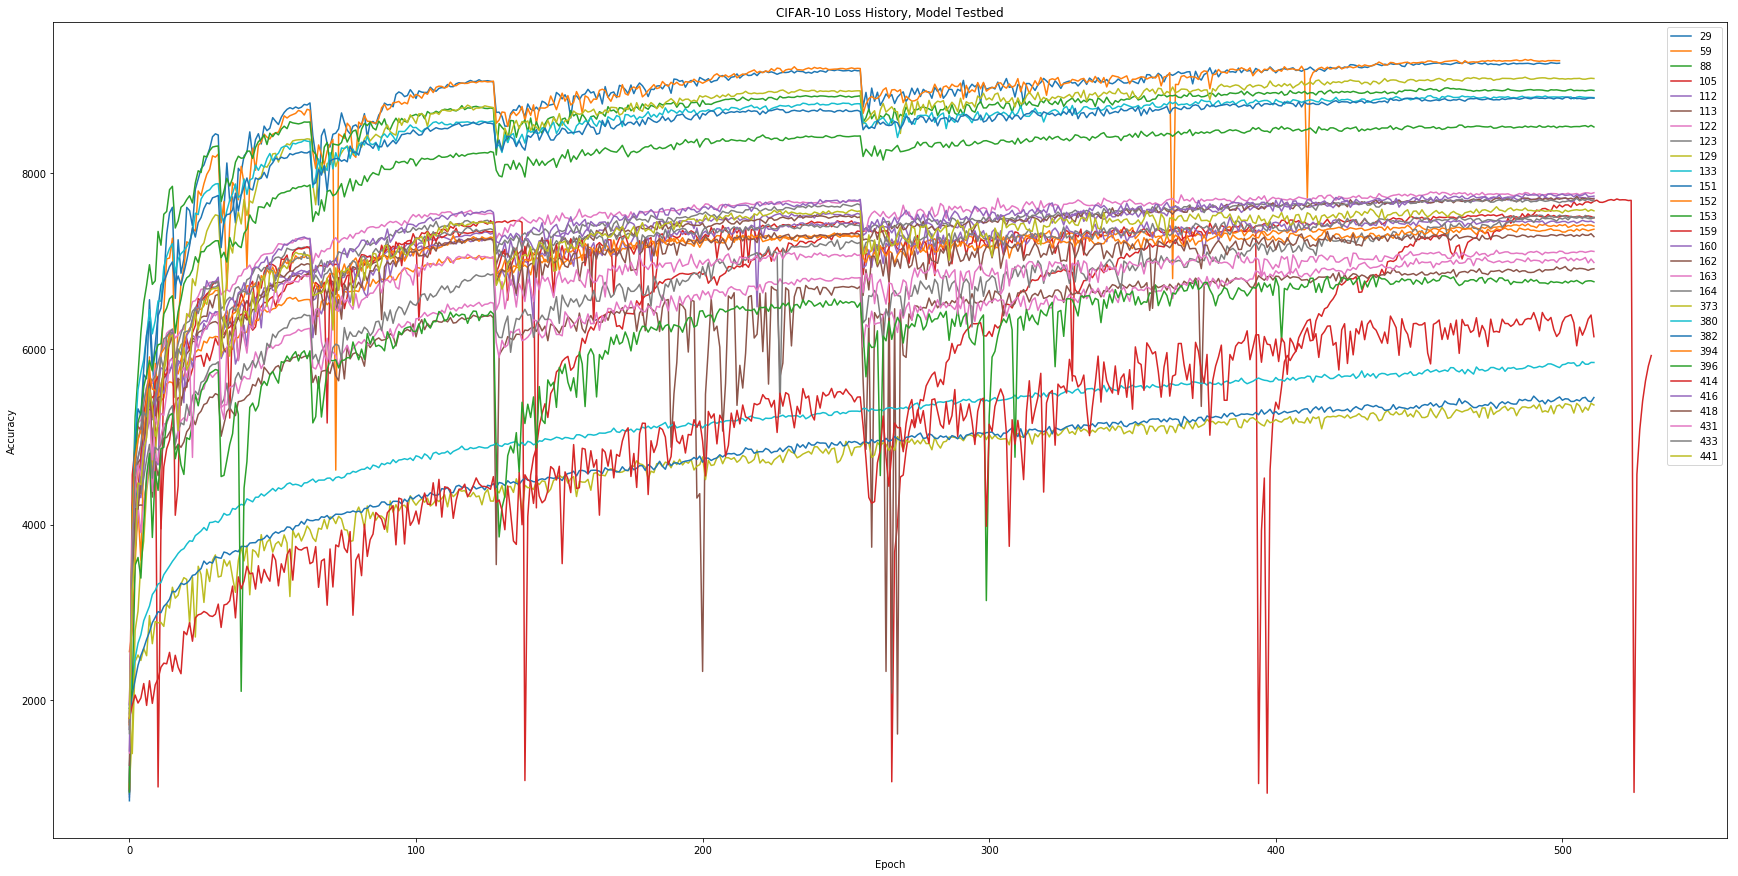

In [475]:
plt.figure(figsize=(30,15))
for i,curve in enumerate(run_stats['curve']):
    if len(curve)>=500:
        plt.plot(curve,label=i)
plt.title("CIFAR-10 Loss History, Model Testbed")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# See Cumulative Maxes of all 512 Epoch Runs

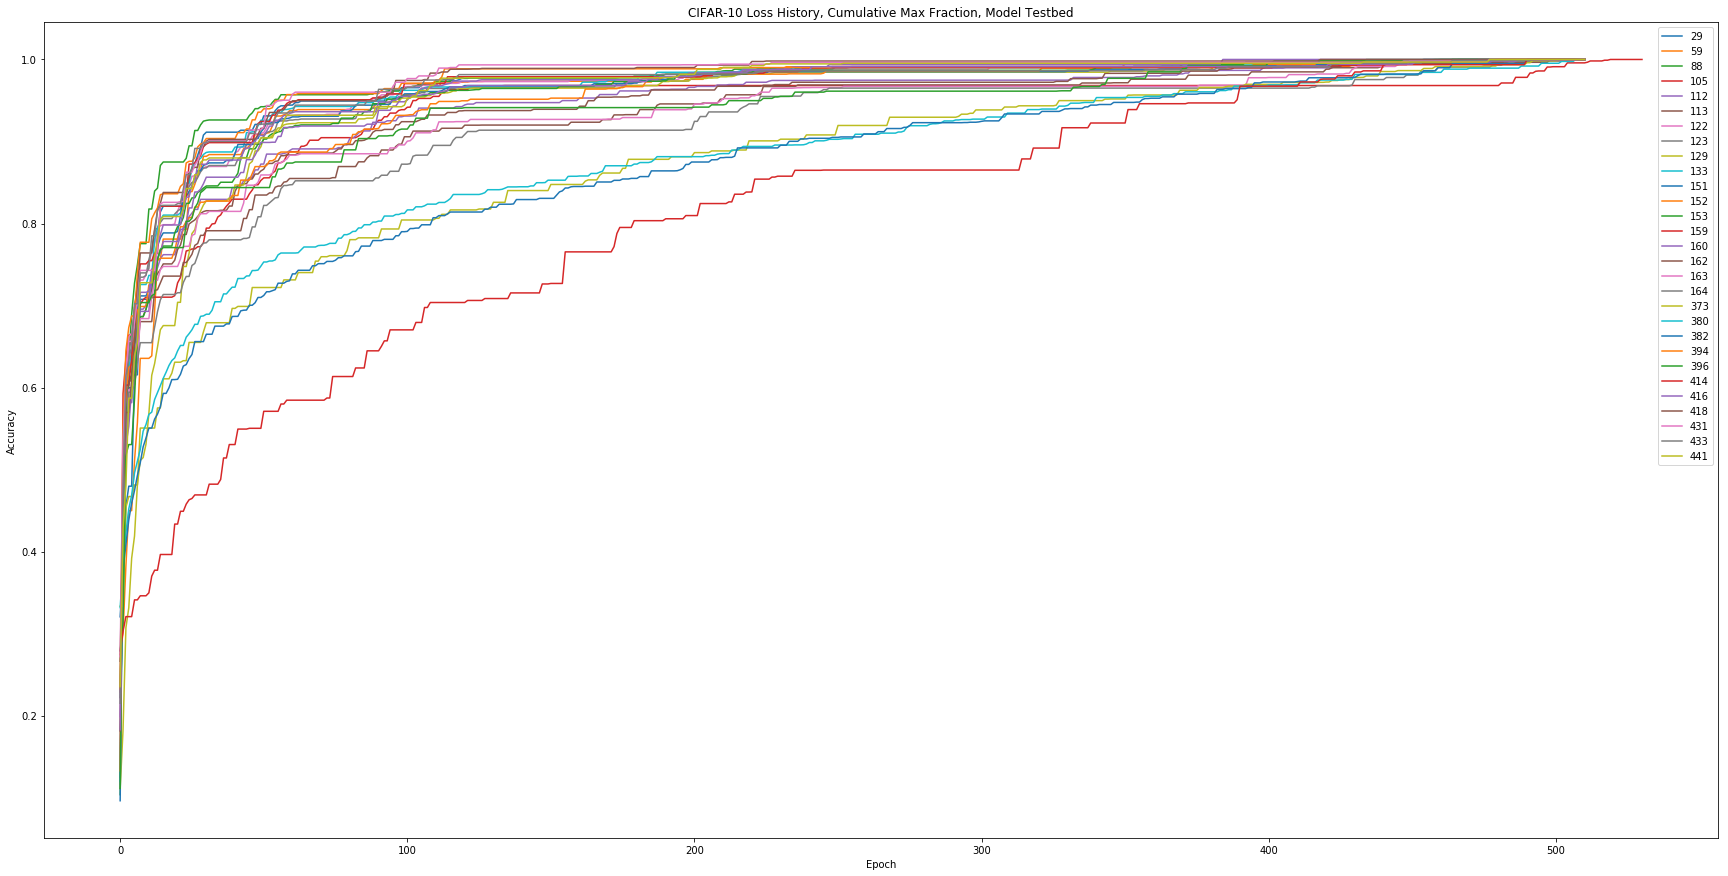

In [476]:
plt.figure(figsize=(30,15))

for i,curve in enumerate(run_stats['curve']):
    if len(curve)>=500:
        cum_max= [max(curve[:i])/max(curve) for i in range(1,len(curve))]
        plt.plot(cum_max,label=i)
plt.title("CIFAR-10 Loss History, Cumulative Max Fraction, Model Testbed")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Macro Train Predictors

In [501]:
# import copy
pd.options.mode.chained_assignment = None

predictor_df = copy.copy(run_stats)
losses = predictor_df[predictor_df['epoch']>=500]
losses['curve']=losses['curve'].apply(lambda x: x+[max(x)]*12 if len(x)==500 else x)
losses['curve']=losses['curve'].apply(lambda x: x[:512] if len(x)>512 else x)
losses['reductions']=losses['cell_types'].apply(sum)
losses['parallel']=losses['cell_matrices'].apply(lambda x: len(x) if len(x)<3 else 1)
losses['cells']=losses['cell_types'].apply(len)
losses['nodes']=losses['cell_matrices'].apply(lambda x: len(x[0]) if len(x)<3 else len(x))


losses = losses[losses['reductions']>4]
for i in range(512):
    if i==0:
        losses['max_curve_{}'.format(i)]=losses['curve'].apply(lambda x:x[0])
    else:
        losses['max_curve_{}'.format(i)]=losses['curve'].apply(lambda x: max(x[:i+1]))
    losses['curve_{}'.format(i)]=losses['curve'].apply(lambda x: x[i])
losses.to_pickle('macro_losses.pkl')




==0==============================


,max_curve_0,params,reductions,parallel,cells,nodes,intercept,pred,_score,%pts error
163,255.477537,20.804316,1.492140e-11,-1610.922323,-449.076380,-527.608902,9328.599413,7017,7046.0,0.29
380,355.073572,273.219759,1.492140e-11,-1610.922323,-648.665882,-633.130682,9328.599413,7064,5857.0,-12.07
394,313.773198,140.990655,1.492140e-11,-1610.922323,-648.665882,-633.130682,9328.599413,6890,7378.0,4.88
160,304.270457,106.467552,1.492140e-11,-1610.922323,-449.076380,-527.608902,9328.599413,7151,7503.0,3.52
382,319.986528,1075.382471,1.492140e-11,-1610.922323,-648.665882,-422.087121,9328.599413,8042,5463.0,-25.79
122,174.704238,578.392746,1.492140e-11,-805.461161,-449.076380,-527.608902,9328.599413,8299,7789.0,-5.10
123,175.983453,1118.507331,1.492140e-11,-1610.922323,-449.076380,-527.608902,9328.599413,8035,7727.0,-3.08


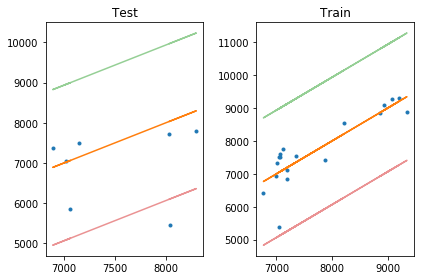

	Intercept: 9328.59941328041
	Coefficients: 
	 max_curve_0: 0.1827 params: 0.0001 reductions: 0.0000 parallel: -805.4612 cells: -49.8974 nodes: -105.5218
	PearsonR: 0.863,0.000
	95%: ±1936.24



==50==============================


,max_curve_50,params,reductions,parallel,cells,nodes,intercept,pred,_score,%pts error
163,3822.993753,1.632117,-1.421085e-13,-235.744228,222.109295,1144.224561,2171.135497,7126,7046.0,-0.80
380,2785.468359,21.434333,-1.421085e-13,-235.744228,320.824537,1373.069473,2171.135497,6436,5857.0,-5.79
394,4378.698164,11.060842,-1.421085e-13,-235.744228,320.824537,1373.069473,2171.135497,8019,7378.0,-6.41
160,4258.716529,8.352474,-1.421085e-13,-235.744228,222.109295,1144.224561,2171.135497,7568,7503.0,-0.65
382,2457.097571,84.364713,-1.421085e-13,-235.744228,320.824537,915.379649,2171.135497,5713,5463.0,-2.50
122,4480.366811,45.375426,-1.421085e-13,-117.872114,222.109295,1144.224561,2171.135497,7945,7789.0,-1.56
123,4421.007477,87.747896,-1.421085e-13,-235.744228,222.109295,1144.224561,2171.135497,7810,7727.0,-0.83


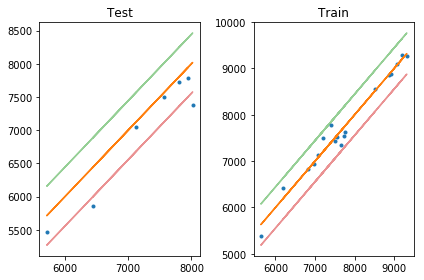

	Intercept: 2171.1354973307843
	Coefficients: 
	 max_curve_50: 0.6315 params: 0.0000 reductions: -0.0000 parallel: -117.8721 cells: 24.6788 nodes: 228.8449
	PearsonR: 0.986,0.000
	95%: ±443.79



==100==============================


,max_curve_100,params,reductions,parallel,cells,nodes,intercept,pred,_score,%pts error
163,4200.040252,1.643856,-1.421085e-13,-184.586322,192.328012,1054.932302,1770.141286,7034,7046.0,0.12
380,3166.581419,21.588502,-1.421085e-13,-184.586322,277.807129,1265.918763,1770.141286,6317,5857.0,-4.60
394,4742.920612,11.140399,-1.421085e-13,-184.586322,277.807129,1265.918763,1770.141286,7883,7378.0,-5.05
160,4721.735037,8.412550,-1.421085e-13,-184.586322,192.328012,1054.932302,1770.141286,7562,7503.0,-0.59
382,2858.728532,84.971513,-1.421085e-13,-184.586322,277.807129,843.945842,1770.141286,5651,5463.0,-1.88
122,4985.892676,45.701793,-1.421085e-13,-92.293161,192.328012,1054.932302,1770.141286,7956,7789.0,-1.67
123,4889.233490,88.379031,-1.421085e-13,-184.586322,192.328012,1054.932302,1770.141286,7810,7727.0,-0.83


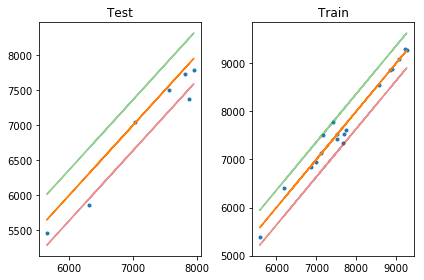

	Intercept: 1770.1412857839523
	Coefficients: 
	 max_curve_100: 0.6620 params: 0.0000 reductions: -0.0000 parallel: -92.2932 cells: 21.3698 nodes: 210.9865
	PearsonR: 0.987,0.000
	95%: ±362.76



==150==============================


,max_curve_150,params,reductions,parallel,cells,nodes,intercept,pred,_score,%pts error
163,4554.353695,1.827921,-2.842171e-13,-137.553107,135.137262,972.717523,1521.723454,7048,7046.0,-0.02
380,3483.233304,24.005794,-2.842171e-13,-137.553107,195.198268,1167.261028,1521.723454,6253,5857.0,-3.96
394,5086.427171,12.387803,-2.842171e-13,-137.553107,195.198268,1167.261028,1521.723454,7845,7378.0,-4.67
160,5065.506851,9.354514,-2.842171e-13,-137.553107,135.137262,972.717523,1521.723454,7566,7503.0,-0.63
382,3164.547094,94.485881,-2.842171e-13,-137.553107,195.198268,778.174019,1521.723454,5616,5463.0,-1.53
122,5285.170212,50.819080,-2.842171e-13,-68.776554,135.137262,972.717523,1521.723454,7896,7789.0,-1.07
123,5206.370340,98.274942,-2.842171e-13,-137.553107,135.137262,972.717523,1521.723454,7796,7727.0,-0.69


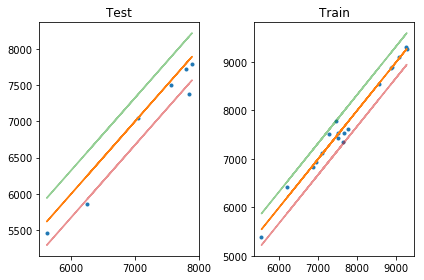

	Intercept: 1521.7234540991967
	Coefficients: 
	 max_curve_150: 0.6973 params: 0.0000 reductions: -0.0000 parallel: -68.7766 cells: 15.0153 nodes: 194.5435
	PearsonR: 0.991,0.000
	95%: ±325.31



==200==============================


,max_curve_200,params,reductions,parallel,cells,nodes,intercept,pred,_score,%pts error
163,5211.062024,0.793113,-1.421085e-13,-59.547206,168.175942,757.353532,958.417558,7036,7046.0,0.10
380,4037.927845,10.415827,-1.421085e-13,-59.547206,242.920805,908.824238,958.417558,6098,5857.0,-2.41
394,5704.560469,5.374920,-1.421085e-13,-59.547206,242.920805,908.824238,958.417558,7760,7378.0,-3.82
160,5771.038072,4.058812,-1.421085e-13,-59.547206,168.175942,757.353532,958.417558,7599,7503.0,-0.96
382,3738.387584,40.996294,-1.421085e-13,-59.547206,242.920805,605.882826,958.417558,5527,5463.0,-0.64
122,5975.945509,22.049792,-1.421085e-13,-29.773603,168.175942,757.353532,958.417558,7852,7789.0,-0.63
123,5901.647011,42.640323,-1.421085e-13,-59.547206,168.175942,757.353532,958.417558,7768,7727.0,-0.41


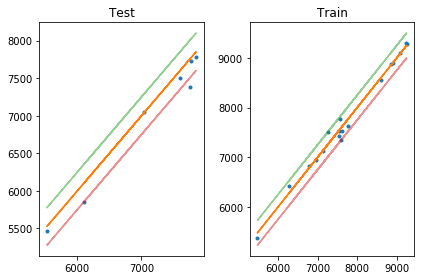

	Intercept: 958.4175578194345
	Coefficients: 
	 max_curve_200: 0.7821 params: 0.0000 reductions: -0.0000 parallel: -29.7736 cells: 18.6862 nodes: 151.4707
	PearsonR: 0.994,0.000
	95%: ±249.53



==250==============================


,max_curve_250,params,reductions,parallel,cells,nodes,intercept,pred,_score,%pts error
163,5615.155958,1.019628,-3.552714e-14,-62.868158,145.753078,548.805171,780.300603,7028,7046.0,0.18
380,4362.575981,13.390614,-3.552714e-14,-62.868158,210.532224,658.566205,780.300603,5962,5857.0,-1.05
394,6035.158071,6.910011,-3.552714e-14,-62.868158,210.532224,658.566205,780.300603,7628,7378.0,-2.50
160,6151.504433,5.218019,-3.552714e-14,-62.868158,145.753078,548.805171,780.300603,7568,7503.0,-0.65
382,4079.549016,52.704941,-3.552714e-14,-62.868158,210.532224,439.044137,780.300603,5499,5463.0,-0.36
122,6345.415035,28.347269,-3.552714e-14,-31.434079,145.753078,548.805171,780.300603,7817,7789.0,-0.28
123,6310.758672,54.818509,-3.552714e-14,-62.868158,145.753078,548.805171,780.300603,7777,7727.0,-0.50


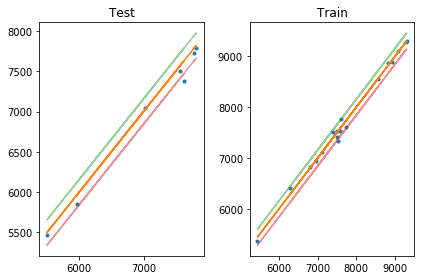

	Intercept: 780.3006026920457
	Coefficients: 
	 max_curve_250: 0.8252 params: 0.0000 reductions: -0.0000 parallel: -31.4341 cells: 16.1948 nodes: 109.7610
	PearsonR: 0.997,0.000
	95%: ±156.72



==300==============================


,max_curve_300,params,reductions,parallel,cells,nodes,intercept,pred,_score,%pts error
163,5766.611923,0.542552,1.421085e-13,-31.827333,140.250740,588.942792,569.930155,7034,7046.0,0.12
380,4595.520081,7.125250,1.421085e-13,-31.827333,202.584402,706.731350,569.930155,6050,5857.0,-1.93
394,6188.848071,3.676871,1.421085e-13,-31.827333,202.584402,706.731350,569.930155,7639,7378.0,-2.61
160,6308.157283,2.776549,1.421085e-13,-31.827333,140.250740,588.942792,569.930155,7578,7503.0,-0.75
382,4273.977524,28.044712,1.421085e-13,-31.827333,202.584402,471.154233,569.930155,5513,5463.0,-0.50
122,6507.005970,15.083804,1.421085e-13,-15.913666,140.250740,588.942792,569.930155,7805,7789.0,-0.16
123,6475.697879,29.169358,1.421085e-13,-31.827333,140.250740,588.942792,569.930155,7772,7727.0,-0.45


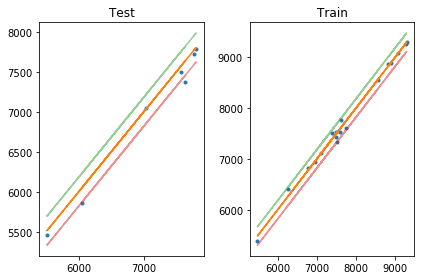

	Intercept: 569.9301552934567
	Coefficients: 
	 max_curve_300: 0.8462 params: 0.0000 reductions: 0.0000 parallel: -15.9137 cells: 15.5834 nodes: 117.7886
	PearsonR: 0.996,0.000
	95%: ±180.99



==350==============================


,max_curve_350,params,reductions,parallel,cells,nodes,intercept,pred,_score,%pts error
163,6192.080069,0.327602,-3.552714e-14,-2.083278,56.501170,352.808736,388.394993,6988,7046.0,0.58
380,5075.415886,4.302341,-3.552714e-14,-2.083278,81.612801,423.370483,388.394993,5971,5857.0,-1.14
394,6645.469351,2.220154,-3.552714e-14,-2.083278,81.612801,423.370483,388.394993,7538,7378.0,-1.60
160,6773.581352,1.676525,-3.552714e-14,-2.083278,56.501170,352.808736,388.394993,7570,7503.0,-0.67
382,4703.800223,16.933850,-3.552714e-14,-2.083278,81.612801,282.246989,388.394993,5470,5463.0,-0.07
122,7012.542036,9.107844,-3.552714e-14,-1.041639,56.501170,352.808736,388.394993,7818,7789.0,-0.29
123,6953.483312,17.612929,-3.552714e-14,-2.083278,56.501170,352.808736,388.394993,7766,7727.0,-0.39


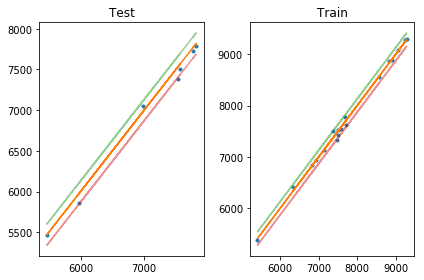

	Intercept: 388.39499273291585
	Coefficients: 
	 max_curve_350: 0.9086 params: 0.0000 reductions: -0.0000 parallel: -1.0416 cells: 6.2779 nodes: 70.5617
	PearsonR: 0.998,0.000
	95%: ±129.75



==400==============================


,max_curve_400,params,reductions,parallel,cells,nodes,intercept,pred,_score,%pts error
163,6666.388020,-0.312105,2.664535e-14,1.171971,-28.342674,149.117801,221.434851,7009,7046.0,0.37
380,5490.023511,-4.098832,2.664535e-14,1.171971,-40.939418,178.941361,221.434851,5846,5857.0,0.11
394,7094.948445,-2.115136,2.664535e-14,1.171971,-40.939418,178.941361,221.434851,7453,7378.0,-0.75
160,7258.439894,-1.597222,2.664535e-14,1.171971,-28.342674,149.117801,221.434851,7600,7503.0,-0.97
382,5139.822892,-16.132844,2.664535e-14,1.171971,-40.939418,119.294241,221.434851,5424,5463.0,0.39
122,7502.225960,-8.677024,2.664535e-14,0.585986,-28.342674,149.117801,221.434851,7836,7789.0,-0.47
123,7419.996533,-16.779801,2.664535e-14,1.171971,-28.342674,149.117801,221.434851,7746,7727.0,-0.19


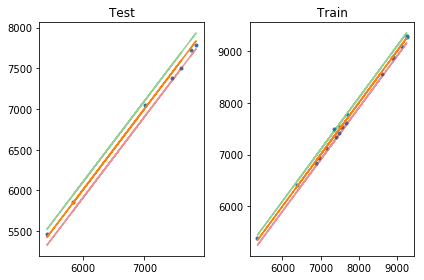

	Intercept: 221.4348509843403
	Coefficients: 
	 max_curve_400: 0.9674 params: -0.0000 reductions: 0.0000 parallel: 0.5860 cells: -3.1492 nodes: 29.8236
	PearsonR: 0.999,0.000
	95%: ±97.40



==450==============================


,max_curve_450,params,reductions,parallel,cells,nodes,intercept,pred,_score,%pts error
163,6991.491243,-0.228160,1.332268e-14,5.961584,-27.147401,11.151041,96.776688,7078,7046.0,-0.32
380,5717.689468,-2.996395,1.332268e-14,5.961584,-39.212912,13.381249,96.776688,5791,5857.0,0.66
394,7311.681853,-1.546241,1.332268e-14,5.961584,-39.212912,13.381249,96.776688,7387,7378.0,-0.09
160,7460.838970,-1.167627,1.332268e-14,5.961584,-27.147401,11.151041,96.776688,7546,7503.0,-0.43
382,5335.847250,-11.793694,1.332268e-14,5.961584,-39.212912,8.920833,96.776688,5396,5463.0,0.67
122,7726.338637,-6.343220,1.332268e-14,2.980792,-27.147401,11.151041,96.776688,7803,7789.0,-0.14
123,7648.776937,-12.266643,1.332268e-14,5.961584,-27.147401,11.151041,96.776688,7723,7727.0,0.04


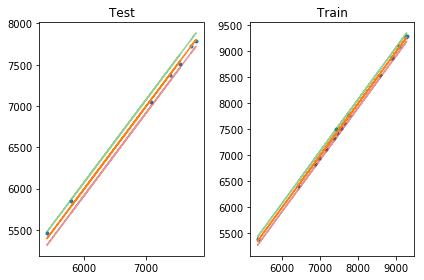

	Intercept: 96.77668775046459
	Coefficients: 
	 max_curve_450: 0.9944 params: -0.0000 reductions: 0.0000 parallel: 2.9808 cells: -3.0164 nodes: 2.2302
	PearsonR: 1.000,0.000
	95%: ±80.24



==500==============================


,max_curve_500,params,reductions,parallel,cells,nodes,intercept,pred,_score,%pts error
163,7037.584344,0.000071,1.665335e-15,-1.695166,-4.976185,-3.409181,22.201437,7049,7046.0,-0.03
380,5823.036720,0.000938,1.665335e-15,-1.695166,-7.187823,-4.091017,22.201437,5832,5857.0,0.25
394,7369.187808,0.000484,1.665335e-15,-1.695166,-7.187823,-4.091017,22.201437,7378,7378.0,0.00
160,7494.038509,0.000365,1.665335e-15,-1.695166,-4.976185,-3.409181,22.201437,7506,7503.0,-0.03
382,5456.475060,0.003690,1.665335e-15,-1.695166,-7.187823,-2.727345,22.201437,5467,5463.0,-0.04
122,7779.696914,0.001985,1.665335e-15,-0.847583,-4.976185,-3.409181,22.201437,7792,7789.0,-0.03
123,7717.770966,0.003838,1.665335e-15,-1.695166,-4.976185,-3.409181,22.201437,7729,7727.0,-0.02


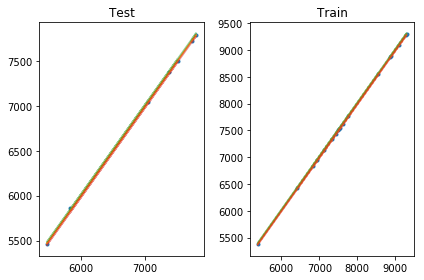

	Intercept: 22.201436542751253
	Coefficients: 
	 max_curve_500: 0.9988 params: 0.0000 reductions: 0.0000 parallel: -0.8476 cells: -0.5529 nodes: -0.6818
	PearsonR: 1.000,0.000
	95%: ±19.14


In [470]:
from sklearn import linear_model
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
import pickle as pkl

train,test = train_test_split(losses,test_size=.25)
funcs = {}
for i in range(512):
    regr = linear_model.LinearRegression()

    column_selector=['max_curve_{}'.format(i),'params','reductions','parallel','cells','nodes']
    train_X = train[column_selector]
    train_Y = train['max']
    
    test_X = test[column_selector]
    test_Y = test['max']
    
    
    
    regr = linear_model.LinearRegression()
    regr.fit(train_X,train_Y)
    x_func = regr.intercept_+np.dot(train_X,regr.coef_)
    pred = regr.intercept_+np.dot(test_X,regr.coef_)
    c95 = np.std(test_Y.values-pred)*1.96
    funcs[i]={'b':regr.intercept_,'m':regr.coef_,'95':c95}
    
    if not i%50:
        print("\n\n\n=={}==============================".format(i))
        xy_df = pd.DataFrame(test_X*regr.coef_)
        xy_df['intercept']=regr.intercept_
        xy_df['pred']=xy_df.apply(lambda x: int(sum(x)),1)
        xy_df['_score']=test_Y
        xy_df['%pts error']=(xy_df['_score']-xy_df['pred'])/100
        display(xy_df)
        #display(test)
        
        plt.subplot(121)
        plt.plot(pred,test_Y,".")
        plt.plot(pred,pred)
        plt.plot(pred,pred+c95,alpha=.5)
        plt.plot(pred,pred-c95,alpha=.5)
        plt.title("Test")
        
        plt.subplot(122)
        plt.plot(x_func,train_Y,".")
        plt.plot(x_func,x_func)
        plt.plot(x_func,x_func+c95,alpha=.5)
        plt.plot(x_func,x_func-c95,alpha=.5)
        plt.title("Train")
        plt.tight_layout()
        
        plt.show()
        print('\tIntercept:', regr.intercept_)
        print('\tCoefficients: \n\t', *["{}: {:.4f}".format(list(train_X)[i],x) for (i,x) in enumerate(regr.coef_)])
        print("\tPearsonR: {:.3f},{:.3f}".format(*pearsonr(x_func,train_Y)))
        print("\t95%: ±{:.2f}".format(c95))
        
pkl.dump(funcs,open('macro_loss_predictors.pkl',"wb"))

# Micro Train Predictors

In [489]:
micro_losses               = copy.copy(run_stats)
micro_losses               = micro_losses[micro_losses['cell_types'].apply(lambda x: x==[1,1])]
micro_losses               = micro_losses[micro_losses['curve'].apply(lambda x: len(x)>=8)]
micro_losses['cell_matrices']   = micro_losses['cell_matrices'].apply(lambda x: x if len(x)<3 else [x])
micro_losses['reductions'] = micro_losses['cell_types'].apply(sum)
micro_losses['curve']      = micro_losses['curve'].apply(lambda x: x[:8] if len(x)>8 else x)
micro_losses['parallel']   = micro_losses['cell_matrices'].apply(len)
micro_losses['cells']      = micro_losses['cell_types'].apply(len)
micro_losses['nodes']      = micro_losses['cell_matrices'].apply(lambda x: len(x[0]) if len(x)<3 else len(x))

for i in range(7):
    if i==0:
        micro_losses['max_curve_{}'.format(i)]=micro_losses['curve'].apply(lambda x:x[0])
    else:
        micro_losses['max_curve_{}'.format(i)]=micro_losses['curve'].apply(lambda x: max(x[:i+1]))
        
micro_losses.to_pickle('micro_losses.pkl')

In [478]:
def top_n(arr):
    return sorted(enumerate(arr),key=lambda x: x[1],reverse=True)




==Epoch 0==============================
Train/test sizes: 570, 100


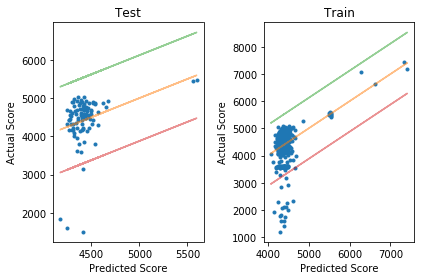

Intercept: 5631.9747307195275
Coefficients: 
 max_curve_0: -0.2163 params: 0.0686 reductions: 0.0000 parallel: -1232.5484 cells: 0.0000 nodes: -35.2512
Pearson Correlation: 0.432,0.000
95%: ±1121.67
Spearman Rank Correlation: 0.2917646776649079
Actual Top-5 in Preds: 0.4
Actual Top-10 in Preds: 0.3
Actual Top-20 in Preds: 0.45
Actual Top-25 in Preds: 0.4


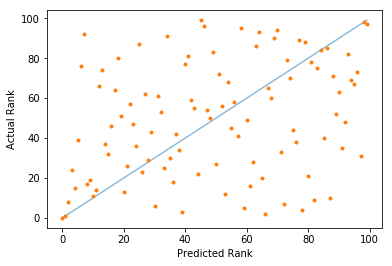




==Epoch 1==============================
Train/test sizes: 570, 100


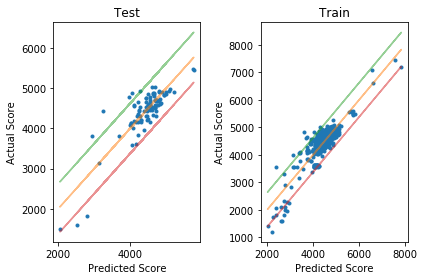

Intercept: 1838.002110918515
Coefficients: 
 max_curve_1: 0.9724 params: 0.0266 reductions: -0.0000 parallel: -1312.8493 cells: 0.0000 nodes: 48.8494
Pearson Correlation: 0.869,0.000
95%: ±622.37
Spearman Rank Correlation: 0.70186260866271
Actual Top-5 in Preds: 0.6
Actual Top-10 in Preds: 0.7
Actual Top-20 in Preds: 0.55
Actual Top-25 in Preds: 0.48


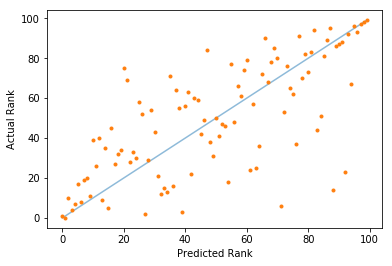




==Epoch 2==============================
Train/test sizes: 570, 100


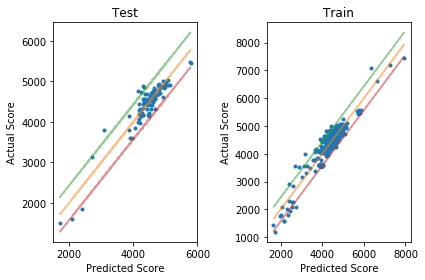

Intercept: 1010.2133671279253
Coefficients: 
 max_curve_2: 1.0322 params: 0.0196 reductions: -0.0000 parallel: -888.5684 cells: 0.0000 nodes: 36.5965
Pearson Correlation: 0.933,0.000
95%: ±429.68
Spearman Rank Correlation: 0.8153533196305106
Actual Top-5 in Preds: 1.0
Actual Top-10 in Preds: 1.0
Actual Top-20 in Preds: 0.85
Actual Top-25 in Preds: 0.76


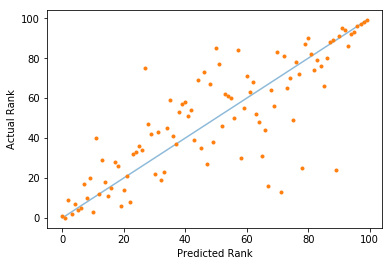




==Epoch 3==============================
Train/test sizes: 570, 100


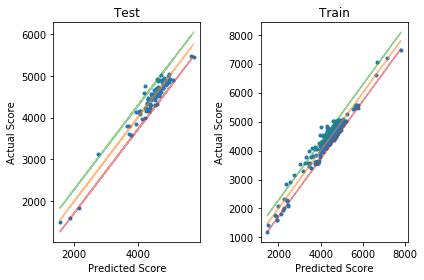

Intercept: 341.9947060557861
Coefficients: 
 max_curve_3: 1.0467 params: 0.0136 reductions: -0.0000 parallel: -342.7117 cells: 0.0000 nodes: 20.6099
Pearson Correlation: 0.965,0.000
95%: ±283.68
Spearman Rank Correlation: 0.9068695694570812
Actual Top-5 in Preds: 1.0
Actual Top-10 in Preds: 0.9
Actual Top-20 in Preds: 0.85
Actual Top-25 in Preds: 0.88


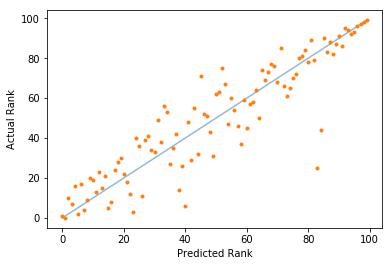




==Epoch 4==============================
Train/test sizes: 570, 100


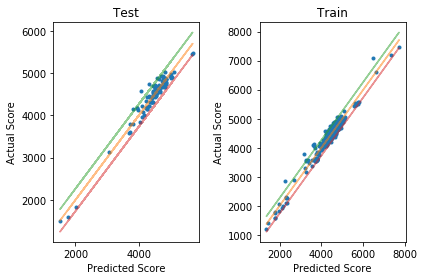

Intercept: 46.28893314900233
Coefficients: 
 max_curve_4: 1.0345 params: 0.0118 reductions: -0.0000 parallel: -78.0301 cells: 0.0000 nodes: 13.3337
Pearson Correlation: 0.978,0.000
95%: ±265.57
Spearman Rank Correlation: 0.9189729250337773
Actual Top-5 in Preds: 1.0
Actual Top-10 in Preds: 0.9
Actual Top-20 in Preds: 0.85
Actual Top-25 in Preds: 0.84


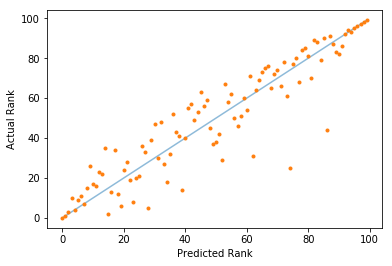




==Epoch 5==============================
Train/test sizes: 570, 100


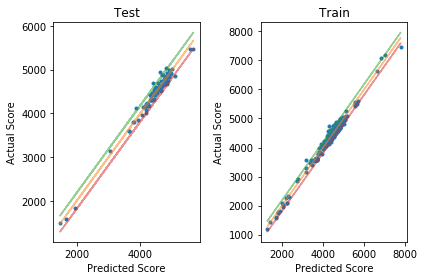

Intercept: -326.6813865469767
Coefficients: 
 max_curve_5: 1.0271 params: 0.0084 reductions: 0.0000 parallel: 256.5595 cells: 0.0000 nodes: 10.0925
Pearson Correlation: 0.989,0.000
95%: ±183.74
Spearman Rank Correlation: 0.9505124574636805
Actual Top-5 in Preds: 1.0
Actual Top-10 in Preds: 0.9
Actual Top-20 in Preds: 0.85
Actual Top-25 in Preds: 0.8


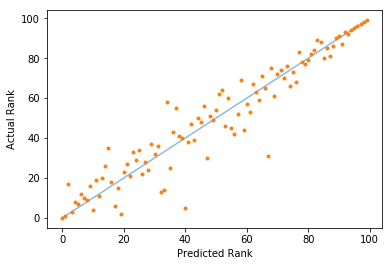




==Epoch 6==============================
Train/test sizes: 570, 100


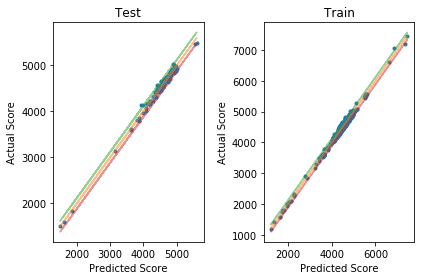

Intercept: -350.7098274820928
Coefficients: 
 max_curve_6: 1.0154 params: 0.0047 reductions: -0.0000 parallel: 297.7222 cells: 0.0000 nodes: 3.3563
Pearson Correlation: 0.996,0.000
95%: ±118.22
Spearman Rank Correlation: 0.9806267721185136
Actual Top-5 in Preds: 1.0
Actual Top-10 in Preds: 1.0
Actual Top-20 in Preds: 1.0
Actual Top-25 in Preds: 0.92


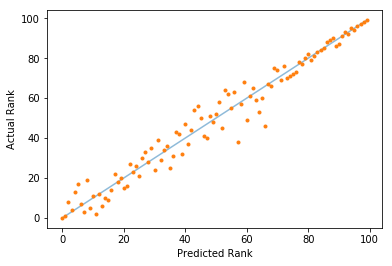

['max_curve_6', 'params', 'reductions', 'parallel', 'cells', 'nodes']
Pearsons [(0, 0.4320491987178293), (1, 0.868698262827763), (2, 0.932649321460122), (3, 0.9650521778139175), (4, 0.978199392639814), (5, 0.9893603898300533), (6, 0.9955411888015336)]
Spearmans [(0, 0.2917646776649079), (1, 0.70186260866271), (2, 0.8153533196305106), (3, 0.9068695694570812), (4, 0.9189729250337773), (5, 0.9505124574636805), (6, 0.9806267721185136)]
Errors [(0, 1121.6663725753376), (1, 622.3715528237562), (2, 429.67655549010124), (3, 283.683860927272), (4, 265.57189448143754), (5, 183.7393461434365), (6, 118.21524304258088)]


In [488]:
from scipy.stats import spearmanr
verbose = True

for selector in [['max_curve','params','reductions','parallel','cells','nodes']]:
    all_pcorrs = []
    all_scorrs = []
    all_errors = []
    for test_run in range(1):
        train,test = train_test_split(micro_losses,test_size=100/len(micro_losses))
        funcs = {}
        spearmans,pearsons,errors = [],[],[]
        for i in range(7):
            regr = linear_model.LinearRegression()

            column_selector = [x+"_"+str(i) if 'curve' in x else x for x in selector]
            train_X = train[column_selector]
            train_Y = train['max']

            test_X = test[column_selector]
            test_Y = test['max']



            regr = linear_model.LinearRegression()
            regr.fit(train_X,train_Y)
            x_func = regr.intercept_+np.dot(train_X,regr.coef_)
            pred = regr.intercept_+np.dot(test_X,regr.coef_)
            c95 = np.std(test_Y.values-pred)*1.96
            funcs[i]={'b':regr.intercept_,'m':regr.coef_,'95':c95}

            if verbose:
                print("\n\n\n==Epoch {}==============================".format(i))
                print("Train/test sizes: {}, {}".format(len(train_X),len(test_X)))
                xy_df = pd.DataFrame(test_X*regr.coef_)
                xy_df['intercept']=regr.intercept_
                xy_df['pred']=xy_df.apply(lambda x: int(sum(x)),1)
                xy_df['_score']=test_Y
                xy_df['%pts error']=(xy_df['_score']-xy_df['pred'])/100
                #display(xy_df)
                #display(test)

                plt.subplot(121)
                plt.plot(pred,test_Y,".")
                plt.plot(pred,pred,alpha=.5)
                plt.plot(pred,pred+c95,alpha=.5)
                plt.plot(pred,pred-c95,alpha=.5)
                plt.xlabel("Predicted Score")
                plt.ylabel("Actual Score")
                plt.title("Test")

                plt.subplot(122)
                plt.plot(x_func,train_Y,".")
                plt.plot(x_func,x_func,alpha=.5)
                plt.plot(x_func,x_func+c95,alpha=.5)
                plt.plot(x_func,x_func-c95,alpha=.5)
                plt.xlabel("Predicted Score")
                plt.ylabel("Actual Score")
                plt.title("Train")
                plt.tight_layout()

                plt.show()

                print('Intercept:', regr.intercept_)
                print('Coefficients: \n', *["{}: {:.4f}".format(list(train_X)[i],x) for (i,x) in enumerate(regr.coef_)])
                print("Pearson Correlation: {:.3f},{:.3f}".format(*pearsonr(x_func,train_Y)))
                print("95%: ±{:.2f}".format(c95))

            spearmans.append(spearmanr(pred,test_Y)[0])
            pearsons.append(pearsonr(x_func,train_Y)[0])
            errors.append(c95)
            if verbose:
                top_tests = top_n(test_Y.values)
                top_preds = top_n(pred)
                print("Spearman Rank Correlation:",spearmanr(pred,test_Y)[0])

                top_test_set = set([x[0] for x in top_tests[:25]])
                top_pred_set = set([x[0] for x in top_preds[:25]])

                print("Actual Top-5 in Preds:",len([1 for x in top_tests[:5] if x[0] in top_pred_set])/5)
                print("Actual Top-10 in Preds:",len([1 for x in top_tests[:10] if x[0] in top_pred_set])/10)
                print("Actual Top-20 in Preds:",len([1 for x in top_tests[:20] if x[0] in top_pred_set])/20)
                print("Actual Top-25 in Preds:",len([1 for x in top_tests[:25] if x[0] in top_pred_set])/25)
                
                
                plt.plot(range(len(top_tests)),range(len(top_tests)),alpha=.5)
                plt.plot(range(len(top_tests)),[[test[0] for test in top_tests].index(x[0]) for x in top_preds],".")
                plt.xlabel("Predicted Rank")
                plt.ylabel("Actual Rank")
                plt.show()
        all_pcorrs.append(pearsons)
        all_scorrs.append(spearmans)
        all_errors.append(errors)
    
    print(column_selector)
    print("Pearsons",list(enumerate(np.mean(all_pcorrs,0))))
    print("Spearmans",list(enumerate(np.mean(all_scorrs,0))))
    print("Errors",list(enumerate(np.mean(all_errors,0))))
        
pkl.dump(funcs,open('micro_loss_predictors.pkl',"wb"))

# See Micro/Macro Correlation

In [490]:
matrices = {}

for idx,row in run_stats.iterrows():
    if not type(row['cell_matrices'])==float:
        if len(row['cell_matrices'])>1:
            cell_matrix = np.array(row['cell_matrices'][0])
        else:
            cell_matrix = np.array(row['cell_matrices'])

        if matrices.get(cell_matrix.tobytes()) is None:
            matrices[cell_matrix.tobytes()] = []
        matrices[cell_matrix.tobytes()].append(row)
matrix_dfs = [pd.DataFrame(matrices[x]) for x in matrices.keys()]

display(matrix_dfs[-5])

,cell_matrices,cell_types,curve,data,drop_path,early_terminate,epoch,epochs,log,lr,lr_schedule,max,momentum,params,per_epoch_time,predictions,prefix,residual_cells,run_date,scale,scales,time_taken,track_progess,track_progress,verbose,weight_decay
1089,"[[[0.0, 12.0, 7.0], [1.0, 0.0, 12.0], [1.0, 0....","[1, 1]","[1219, 4143, 4217, 4472, 4610, 4657, 4649, 4746]",NaN,True,False,8,8.0,True,0.01,"{'type': 'cosine', 'lr_min': 1e-05, 'lr_max': ...",4746.0,0.9,5906.0,7.38 s,"[4429.0, 4902.0, 4716.0, 4830.0, 4885.0, 4826....","IncubatingCell350:n:3,c:0.724,m:0,id:IndiaBilt...",NaN,2019-01-17 02:18:30,2.0,"(2.0, 0.5)","1 min, 7 s",NaN,True,False,0.0001


In [502]:
pairs = []
matrix_id=0

for matrix_df in matrix_dfs:
    micro_scores,macro_scores = [],[]
    micro_stats,macro_stats = [],[]
    micro,macro=False,False
    
    cell_counts = []
    for idx,row in matrix_df.iterrows():
        if len(row['cell_types'])==2 and len(row['curve'])>0:
            micro_scores.append(row['curve'][-1])
            micro_stats.append(dict(("micro_"+k,v) for (k,v) in row.items()))
            micro=True
        elif sum(row['cell_types'])==5 and len(row['curve'])==512:
            macro_scores.append(max(row['curve']))
            macro_stats.append(dict(("macro_"+k,v) for (k,v) in row.items()))
            macro=True
    if micro and macro:
        matrix_id+=1
    
    for i,micro in enumerate(micro_scores):
        for j,macro in enumerate(macro_scores):
            pair_dict = {"_score_micro":micro,"_score_macro":macro,"_matrix_id":matrix_id}
            pair_dict.update(micro_stats[i])
            pair_dict.update(macro_stats[j])
            pairs.append(pair_dict)
            
pair_df = pd.DataFrame(pairs)
pair_df['micro_reductions']=pair_df['micro_cell_types'].apply(sum)
pair_df['macro_reductions']=pair_df['macro_cell_types'].apply(sum)
pair_df['micro_cells']=pair_df['micro_cell_types'].apply(len)
pair_df['macro_cells']=pair_df['macro_cell_types'].apply(len)
pair_df['macro_cell_parallel']=pair_df['macro_cell_matrices'].apply(len)
pair_df.to_pickle('pair_losses.pkl')



=== Macro Benchmark None ===
Intercept: 4090.455746174236
Coefficients: 
 _score_micro: 0.5936 macro_cells: 53.1419 micro_params: 0.0127 macro_params: 0.0000 macro_cell_parallel: -170.2063


,_score_micro,macro_cells,micro_params,macro_params,macro_cell_parallel,intercept,pred,_score_macro,%pts error
0,3407.218834,690.844503,299.621739,597.391935,-170.206253,4090.455746,8915.326504,9096,1.806735
1,3407.218834,478.276963,299.621739,996.567748,-340.412506,4090.455746,8931.728524,8886,-0.457285
2,3407.218834,478.276963,299.621739,500.221178,-170.206253,4090.455746,8605.588207,8867,2.614118
3,3407.218834,478.276963,299.621739,555.210957,-340.412506,4090.455746,8490.371733,8551,0.606283
4,2925.815615,690.844503,865.808688,597.391935,-170.206253,4090.455746,9000.110234,9096,0.958898
5,2925.815615,478.276963,865.808688,996.567748,-340.412506,4090.455746,9016.512255,8886,-1.305123
6,2925.815615,478.276963,865.808688,500.221178,-170.206253,4090.455746,8690.371938,8867,1.766281
7,2925.815615,478.276963,865.808688,555.210957,-340.412506,4090.455746,8575.155464,8551,-0.241555
8,2799.974083,478.276963,283.621717,228.853726,-170.206253,4090.455746,7710.975983,7789,0.780240
9,2799.974083,478.276963,283.621717,442.561860,-340.412506,4090.455746,7754.477864,7727,-0.274779


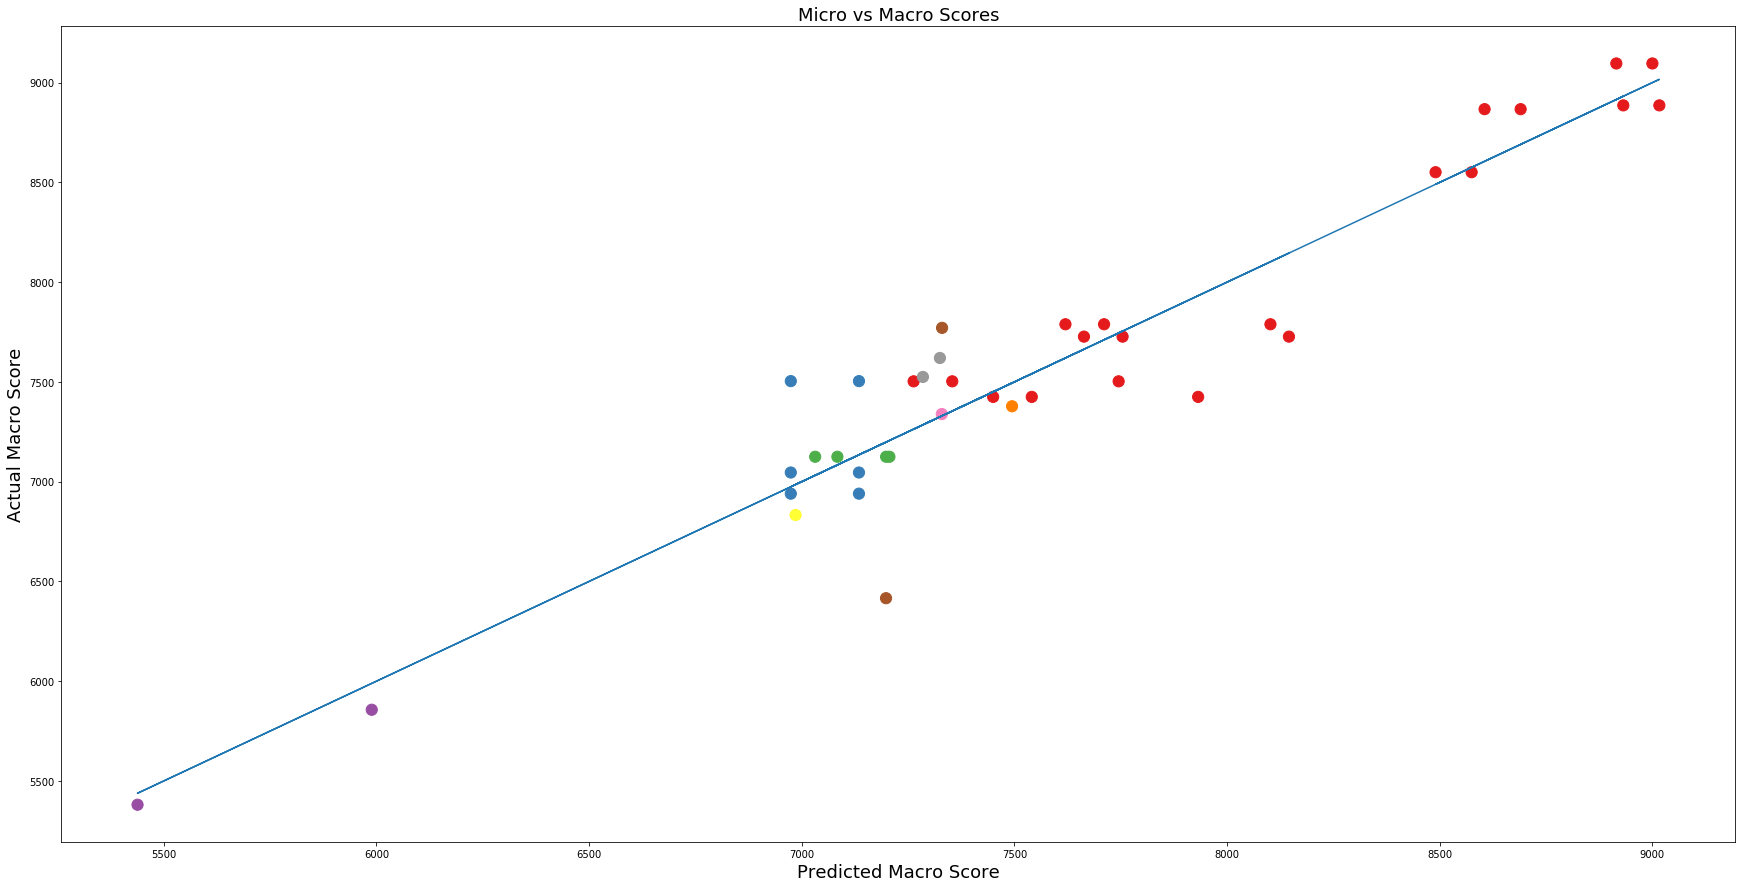

Pearson:  0.95,p=1.2037212462637099e-20
Spearman: 0.87,p=7.15102485628108e-13
Mean Absolute Error: 1.83 %pts


=== Macro Benchmark 0 ===
Intercept: 4094.6572756236355
Coefficients: 
 _score_micro: 0.5969 macro_cells: 41.1620 micro_params: 0.0126 macro_params: 0.0000 macro_cell_parallel: -223.2695 macro_benchmark: 0.1326


,_score_micro,macro_cells,micro_params,macro_params,macro_cell_parallel,macro_benchmark,intercept,pred,_score_macro,%pts error
0,3426.189124,535.105527,297.672930,647.297819,-223.269513,133.624002,4094.657276,8911.277163,9096,1.847228
1,3426.189124,370.457672,297.672930,1079.820619,-446.539027,141.180121,4094.657276,8963.438715,8886,-0.774387
2,3426.189124,370.457672,297.672930,542.009455,-223.269513,113.209224,4094.657276,8620.926167,8867,2.460738
3,3426.189124,370.457672,297.672930,601.593058,-446.539027,126.333009,4094.657276,8470.364043,8551,0.806360
4,2942.105609,535.105527,860.177267,647.297819,-223.269513,133.624002,4094.657276,8989.697985,9096,1.063020
5,2942.105609,370.457672,860.177267,1079.820619,-446.539027,141.180121,4094.657276,9041.859537,8886,-1.558595
6,2942.105609,370.457672,860.177267,542.009455,-223.269513,113.209224,4094.657276,8699.346989,8867,1.676530
7,2942.105609,370.457672,860.177267,601.593058,-446.539027,126.333009,4094.657276,8548.784865,8551,0.022151
8,2815.563432,370.457672,281.776975,247.972075,-223.269513,126.730700,4094.657276,7713.888616,7789,0.751114
9,2815.563432,370.457672,281.776975,479.533301,-446.539027,127.658644,4094.657276,7723.108274,7727,0.038917


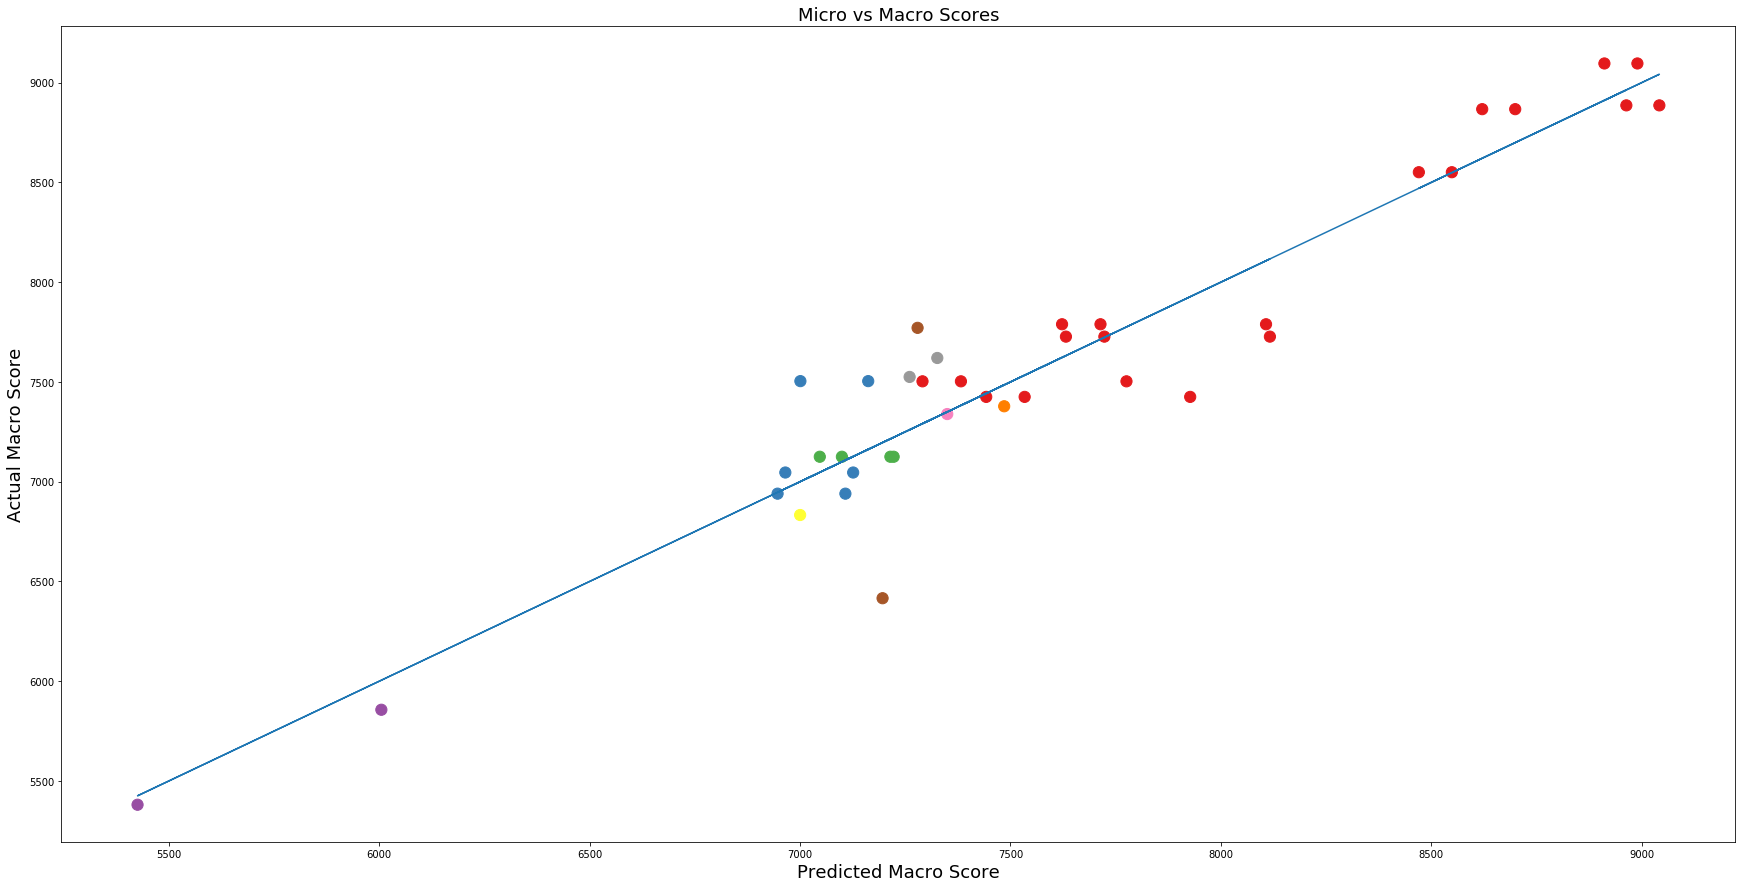

Pearson:  0.95,p=1.0531764525059001e-20
Spearman: 0.87,p=5.639704070169522e-13
Mean Absolute Error: 1.82 %pts


=== Macro Benchmark 1 ===
Intercept: 3850.488308535504
Coefficients: 
 _score_micro: 0.5552 macro_cells: 68.6454 micro_params: 0.0126 macro_params: 0.0000 macro_cell_parallel: -208.8170 macro_benchmark: 0.0913


,_score_micro,macro_cells,micro_params,macro_params,macro_cell_parallel,macro_benchmark,intercept,pred,_score_macro,%pts error
0,3186.714824,892.390512,296.483324,616.819853,-208.817021,151.690968,3850.488309,8785.770769,9096,3.102292
1,3186.714824,617.808816,296.483324,1028.977352,-417.634042,372.290891,3850.488309,8935.129473,8886,-0.491295
2,3186.714824,617.808816,296.483324,516.488984,-208.817021,363.163877,3850.488309,8622.331112,8867,2.446689
3,3186.714824,617.808816,296.483324,573.267098,-417.634042,380.140123,3850.488309,8487.268450,8551,0.637315
4,2736.466440,892.390512,856.739696,616.819853,-208.817021,151.690968,3850.488309,8895.778757,9096,2.002212
5,2736.466440,617.808816,856.739696,1028.977352,-417.634042,372.290891,3850.488309,9045.137461,8886,-1.591375
6,2736.466440,617.808816,856.739696,516.488984,-208.817021,363.163877,3850.488309,8732.339100,8867,1.346609
7,2736.466440,617.808816,856.739696,573.267098,-417.634042,380.140123,3850.488309,8597.276439,8551,-0.462764
8,2618.768959,617.808816,280.650895,236.296329,-208.817021,374.025023,3850.488309,7769.221310,7789,0.197787
9,2618.768959,617.808816,280.650895,456.954514,-417.634042,376.945668,3850.488309,7783.983119,7727,-0.569831


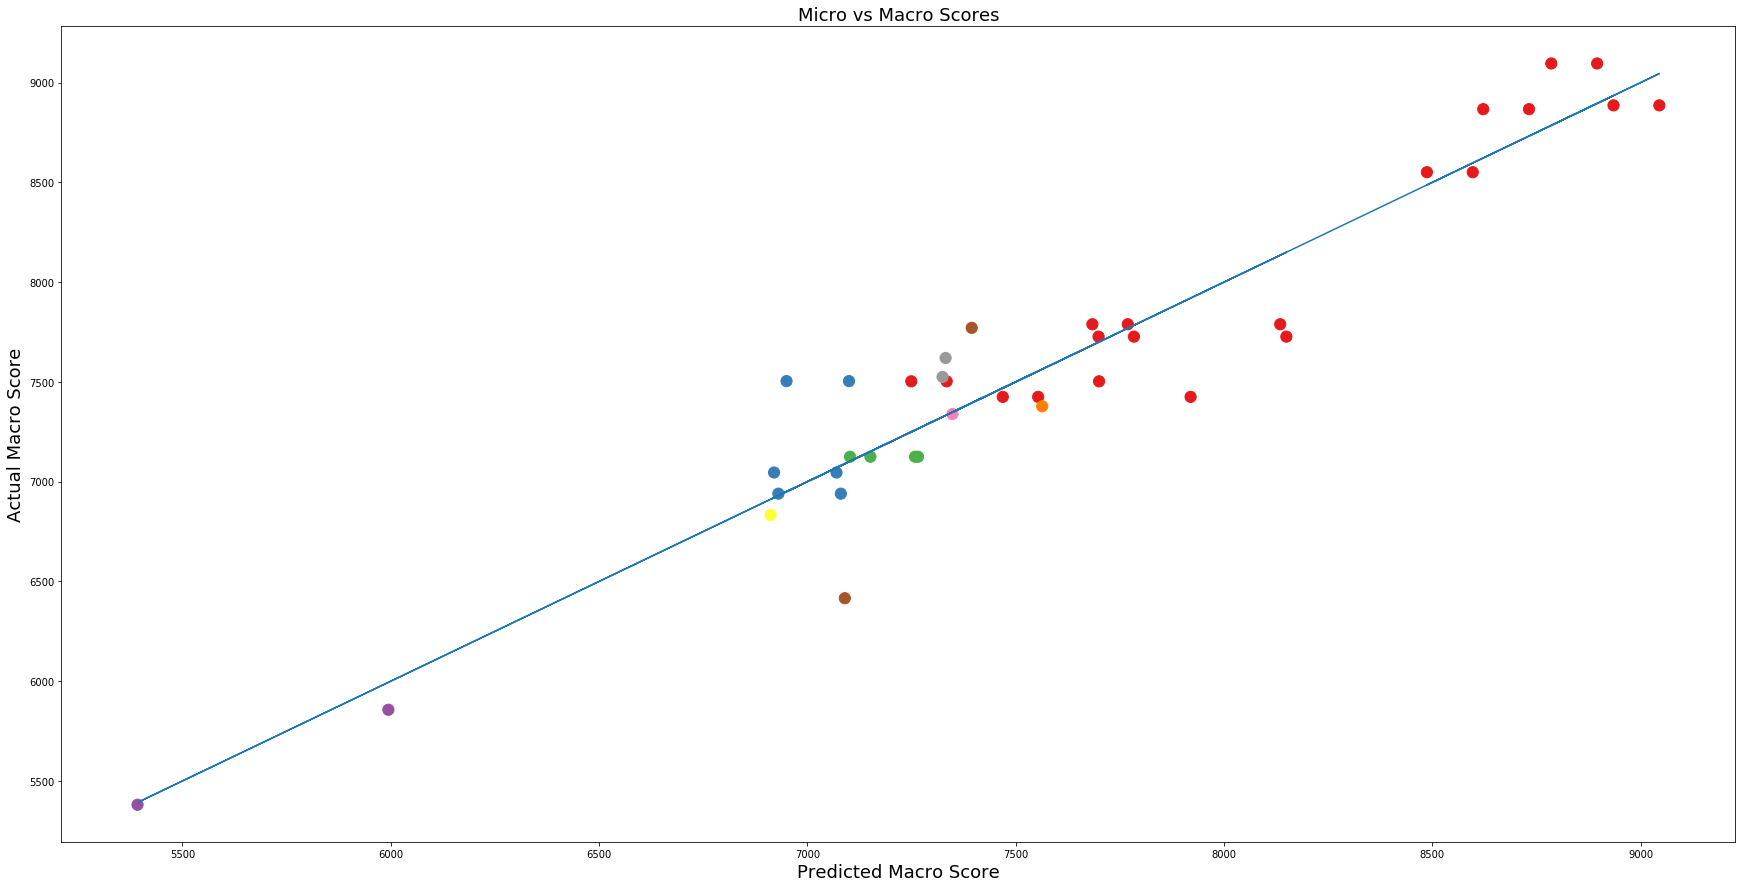

Pearson:  0.95,p=5.194578803613261e-21
Spearman: 0.88,p=9.892021575167148e-14
Mean Absolute Error: 1.80 %pts


=== Macro Benchmark 10 ===
Intercept: 3410.2514762159317
Coefficients: 
 _score_micro: 0.4870 macro_cells: 62.4636 micro_params: 0.0122 macro_params: 0.0000 macro_cell_parallel: -135.3646 macro_benchmark: 0.2078


,_score_micro,macro_cells,micro_params,macro_params,macro_cell_parallel,macro_benchmark,intercept,pred,_score_macro,%pts error
0,2795.204616,812.026248,287.813405,460.598140,-135.364640,1074.408903,3410.251476,8704.938149,9096,3.910619
1,2795.204616,562.172018,287.813405,768.368677,-270.729279,1360.308468,3410.251476,8913.389381,8886,-0.273894
2,2795.204616,562.172018,287.813405,385.678029,-135.364640,1325.609901,3410.251476,8631.364807,8867,2.356352
3,2795.204616,562.172018,287.813405,428.075973,-270.729279,1256.628320,3410.251476,8469.416530,8551,0.815835
4,2400.272396,812.026248,831.686471,460.598140,-135.364640,1074.408903,3410.251476,8853.878994,9096,2.421210
5,2400.272396,562.172018,831.686471,768.368677,-270.729279,1360.308468,3410.251476,9062.330227,8886,-1.763302
6,2400.272396,562.172018,831.686471,385.678029,-135.364640,1325.609901,3410.251476,8780.305652,8867,0.866943
7,2400.272396,562.172018,831.686471,428.075973,-270.729279,1256.628320,3410.251476,8618.357375,8551,-0.673574
8,2297.034873,562.172018,272.443957,176.449654,-135.364640,1214.657599,3410.251476,7797.644938,7789,-0.086449
9,2297.034873,562.172018,272.443957,341.221831,-270.729279,1213.826496,3410.251476,7826.221372,7727,-0.992214


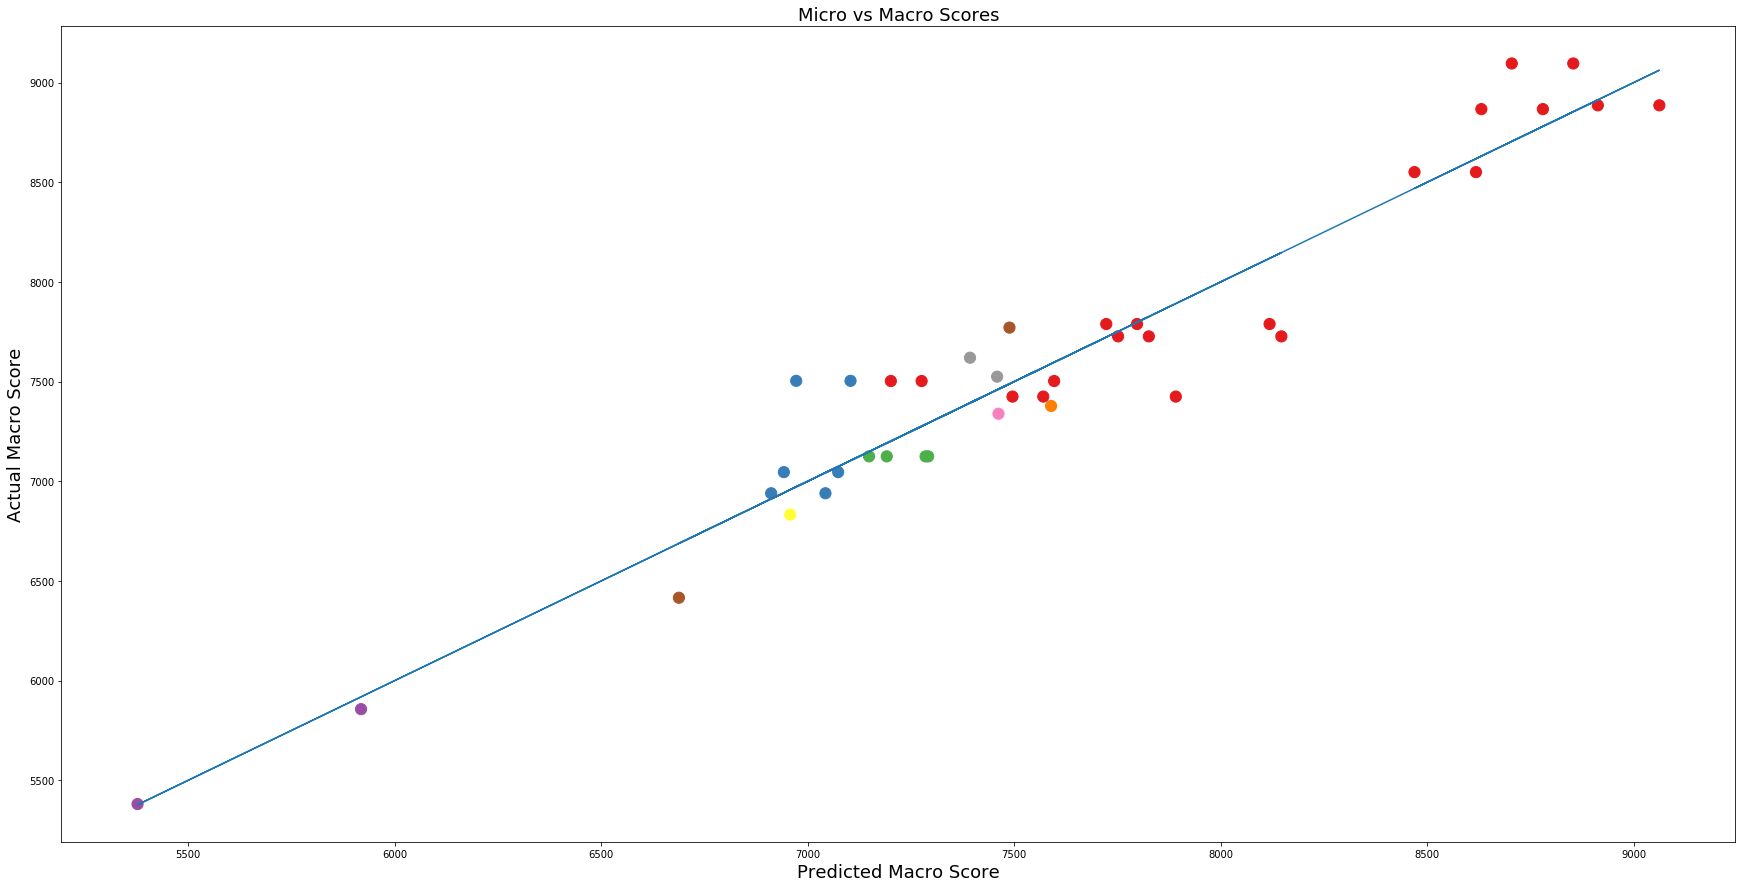

Pearson:  0.96,p=8.36061379631353e-23
Spearman: 0.89,p=3.041177248774458e-14
Mean Absolute Error: 1.68 %pts


=== Macro Benchmark 50 ===
Intercept: 3437.337613989941
Coefficients: 
 _score_micro: 0.2892 macro_cells: 21.4019 micro_params: 0.0070 macro_params: 0.0000 macro_cell_parallel: -108.7697 macro_benchmark: 0.3737


,_score_micro,macro_cells,micro_params,macro_params,macro_cell_parallel,macro_benchmark,intercept,pred,_score_macro,%pts error
0,1660.021946,278.224284,165.153894,372.608086,-108.76968,3072.459156,3437.337614,8877.035300,9096,2.189647
1,1660.021946,192.616812,165.153894,621.583886,-217.53936,3043.311526,3437.337614,8902.486319,8886,-0.164863
2,1660.021946,192.616812,165.153894,312.000288,-108.76968,3034.716712,3437.337614,8693.077586,8867,1.739224
3,1660.021946,192.616812,165.153894,346.298769,-217.53936,2885.241686,3437.337614,8469.131362,8551,0.818686
4,1425.478775,278.224284,477.240660,372.608086,-108.76968,3072.459156,3437.337614,8954.578895,9096,1.414211
5,1425.478775,192.616812,477.240660,621.583886,-217.53936,3043.311526,3437.337614,8980.029914,8886,-0.940299
6,1425.478775,192.616812,477.240660,312.000288,-108.76968,3034.716712,3437.337614,8770.621181,8867,0.963788
7,1425.478775,192.616812,477.240660,346.298769,-217.53936,2885.241686,3437.337614,8546.674957,8551,0.043250
8,1364.167860,192.616812,156.334554,142.741714,-108.76968,2651.313271,3437.337614,7835.742145,7789,-0.467421
9,1364.167860,192.616812,156.334554,276.036749,-217.53936,2616.186640,3437.337614,7825.140869,7727,-0.981409


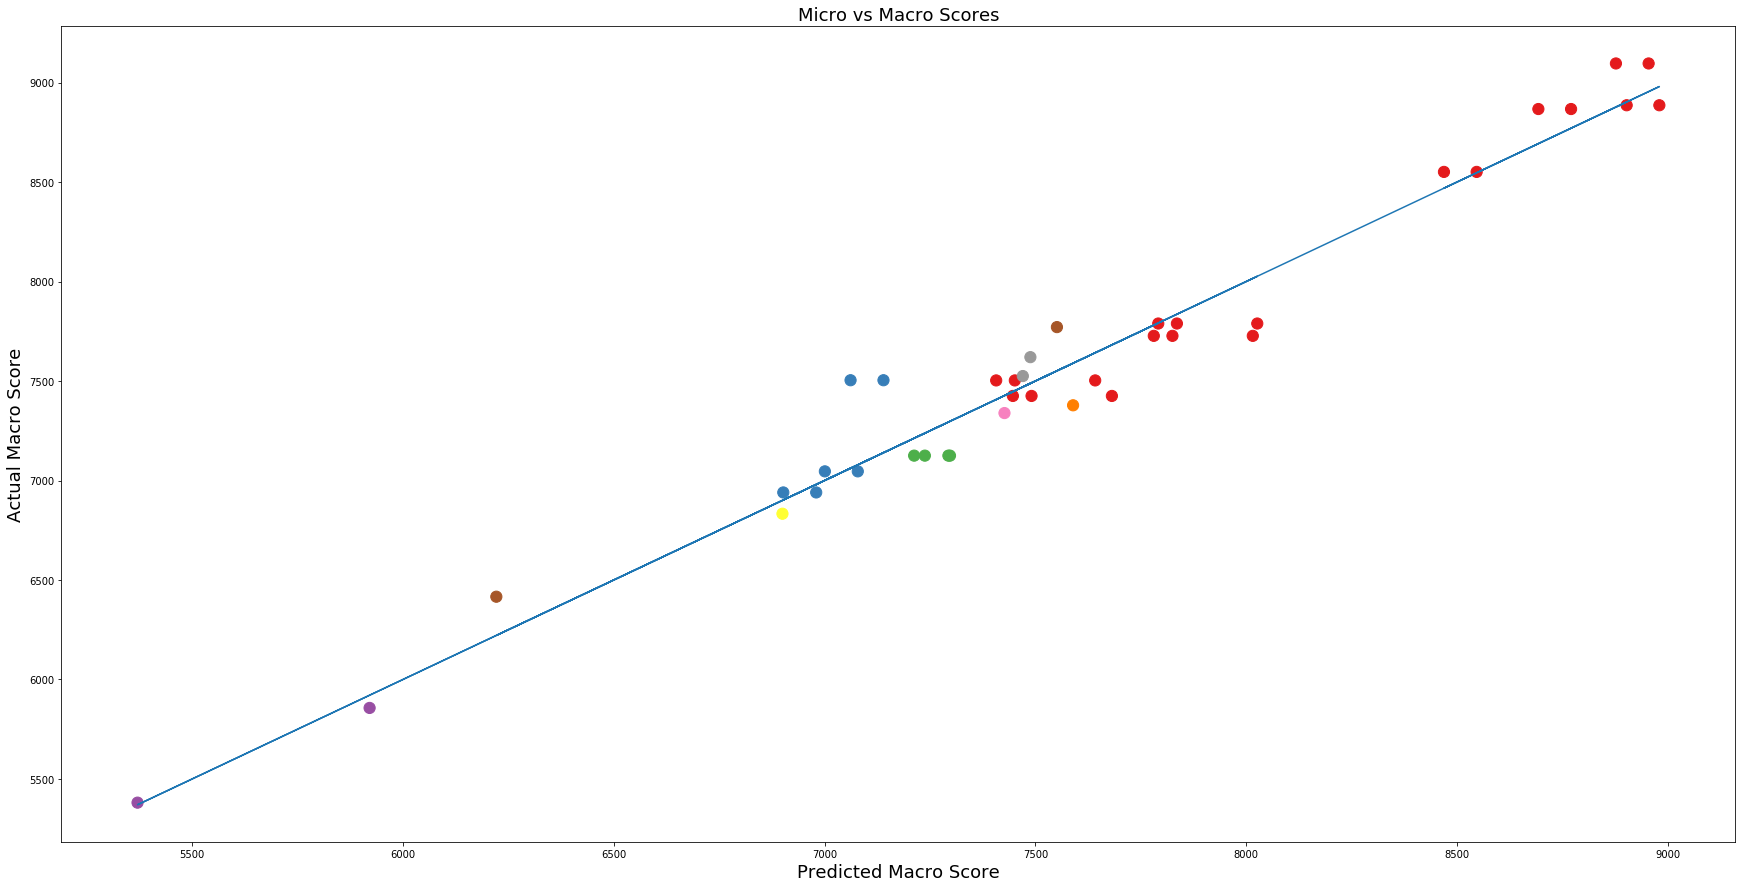

Pearson:  0.98,p=5.646545539132354e-28
Spearman: 0.93,p=1.154243791981148e-17
Mean Absolute Error: 1.21 %pts


In [499]:
from sklearn import linear_model
import copy

for benchmark in [None,0,1,10,50]:
    print("\n\n=== Macro Benchmark {} ===".format(benchmark))

    if benchmark is None:
        X = pair_df[['_score_micro','macro_cells','micro_params','macro_params','macro_cell_parallel']]
    else:
        pair_df['macro_benchmark']=pair_df['macro_curve'].apply(lambda x: x[benchmark])
        X = pair_df[['_score_micro','macro_cells','micro_params','macro_params','macro_cell_parallel','macro_benchmark']]
    Y = pair_df['_score_macro']

    regr = linear_model.LinearRegression()
    regr.fit(X,Y)
    print('Intercept:', regr.intercept_)
    print('Coefficients: \n', *["{}: {:.4f}".format(list(X)[i],x) for (i,x) in enumerate(regr.coef_)])
    x_func = regr.intercept_+np.dot(X,regr.coef_)


    xy_df = pd.DataFrame(X*regr.coef_)
    xy_df['intercept']=regr.intercept_
    xy_df['pred']=xy_df.apply(sum,1)
    xy_df['_score_macro']=Y
    xy_df['%pts error']=(xy_df['_score_macro']-xy_df['pred'])/100
    display(xy_df)

    plt.figure(figsize=(30,15))
    plt.scatter(x_func,Y,c=pair_df['_matrix_id'],marker=".",s=500,cmap='Set1')
    plt.plot(x_func,x_func)
    plt.title("Micro vs Macro Scores",fontsize=18)
    plt.xlabel("Predicted Macro Score",fontsize=18)
    plt.ylabel("Actual Macro Score",fontsize=18)
    plt.show()


    print("Pearson:  {:.2f},p={}".format(*pearsonr(x_func,Y)))
    print("Spearman: {:.2f},p={}".format(*spearmanr(x_func,Y)))
    print("Mean Absolute Error: {:.2f} %pts".format(mae(x_func,Y)/100))